#### Config
- https://github.com/tensorflow/models/blob/master/research/im2txt/im2txt/configuration.py
- batch: 32
- img_size: 299, 299
- embedding size and output size for lstm= 512
- lstm dropout 0.7

#### Image procressing
- https://github.com/tensorflow/models/blob/master/research/im2txt/im2txt/ops/image_processing.py
- resize to 346, 346
- then center crop or pad to 299, 299

#### Net
- https://github.com/tensorflow/models/blob/master/research/im2txt/im2txt/ops/image_embedding.py (end)
- https://github.com/tensorflow/models/blob/master/research/im2txt/im2txt/show_and_tell_model.py (198)
- seems like they take the activations of the last layer.
- then they do an average pooling, dropout and flatten
- then they do a fully connected layer to get the dimensionality of the emedding space


In [3]:
dpath = '/data/image_captioning/flikr8/Flicker8k_Dataset/'

In [228]:
from torchvision.models import inception_v3
from torchvision import transforms
from torch.autograd import Variable
from glob import glob
from PIL import Image
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

### Explore

In [6]:
imgs = glob(dpath+'*.jpg'); len(imgs)

8091

In [13]:
szs = []
for img in imgs:
    szs.append(Image.open(img).size)
szs = np.array(szs)

In [118]:
twoHShortest = np.argsort(szs[:, 1])[:200]
twoHSlimmest = np.argsort(szs[:, 0])[:200]

In [123]:
cropScale = transforms.Compose([transforms.CenterCrop((299, 299)), transforms.Scale(299)])

In [124]:
scaleCrop = transforms.Compose([transforms.Scale(299), transforms.CenterCrop((299, 299))])

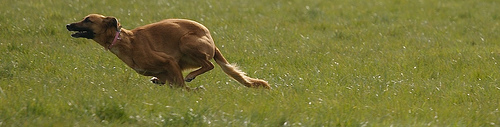

In [125]:
shortest = Image.open(imgs[twoHShortest[0]]); shortest

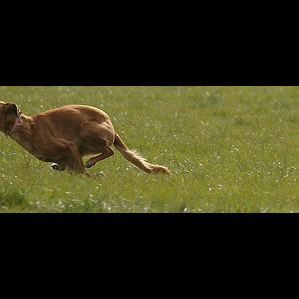

In [126]:
cropScale(shortest)

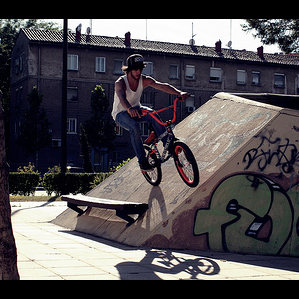

In [129]:
cropScale(Image.open(imgs[twoHShortest[100]]))

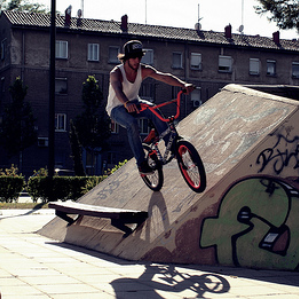

In [130]:
scaleCrop(Image.open(imgs[twoHShortest[100]]))

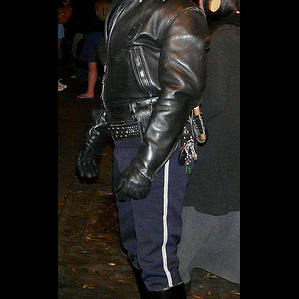

In [131]:
cropScale(Image.open(imgs[twoHSlimmest[2]]))

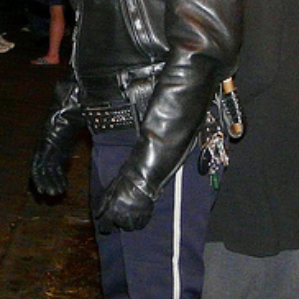

In [132]:
scaleCrop(Image.open(imgs[twoHSlimmest[2]]))

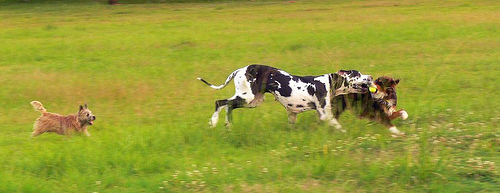

In [133]:
Image.open(imgs[twoHShortest[15]])

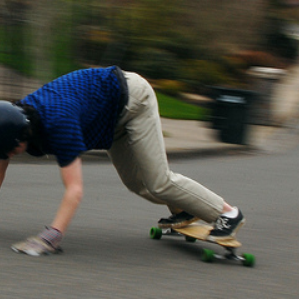

In [134]:
scaleCrop(Image.open(imgs[twoHShortest[49]]))

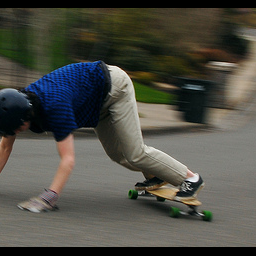

In [116]:
cropScale(Image.open(imgs[twoHShortest[49]]))

In [139]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preproc = transforms.Compose([scaleCrop, transforms.ToTensor(), normalize])

In [142]:
test_img = preproc(Image.open(imgs[0])); test_img.size()

torch.Size([3, 299, 299])

In [191]:
net = inception_v3(pretrained=True)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  m.weight.data.copy_(values)


In [200]:
sd = net.state_dict()

In [297]:
class FeatureExtractor(nn.Module):
    def __init__(self, subm):
        super(FeatureExtractor, self).__init__()

        self.subm = subm

    def forward(self, x):
        outputs = []
        for name, module in self.subm._modules.items():            
            if name == 'AuxLogits':
                continue
            if name == 'fc':
                break 
            x = module(x)
            print(x.size())
        return x


In [298]:
net_cnn = FeatureExtractor(net)

In [299]:
net_cnn(Variable(test_img.unsqueeze(0))).size()

torch.Size([1, 32, 149, 149])
torch.Size([1, 32, 147, 147])
torch.Size([1, 64, 147, 147])
torch.Size([1, 80, 147, 147])
torch.Size([1, 192, 145, 145])
torch.Size([1, 256, 145, 145])
torch.Size([1, 288, 145, 145])
torch.Size([1, 288, 145, 145])
torch.Size([1, 768, 72, 72])
torch.Size([1, 768, 72, 72])
torch.Size([1, 768, 72, 72])
torch.Size([1, 768, 72, 72])
torch.Size([1, 768, 72, 72])
torch.Size([1, 1280, 35, 35])
torch.Size([1, 2048, 35, 35])
torch.Size([1, 2048, 35, 35])


torch.Size([1, 2048, 35, 35])

In [250]:
class FeatureExtractor2(nn.Module):
    def __init__(self, submodule):
        super(FeatureExtractor2, self).__init__()
        for name, module in submodule._modules.items():
            if name != 'AuxLogits' and name != 'fc':
                self.add_module(name, module)
        o = OrderedDict({k:v for k, v in submodule.state_dict().items() if k.find('Aux') < 0 and k.find('fc') < 0 })
        self.load_state_dict(o)

    def forward(self, x):
        outputs = []
        for name, module in self._modules.items():            
            x = module(x)
        return x


In [251]:
cnn2  = FeatureExtractor2(net)

In [253]:
cnn2(Variable(test_img.unsqueeze(0))).size()

torch.Size([1, 2048, 35, 35])

In [250]:
class FeatureExtractor3(nn.Module):
    def __init__(self, submodule):
        super(FeatureExtractor2, self).__init__()
        for name, module in submodule._modules.items():
            if name != 'AuxLogits' and name != 'fc':
                self.add_module(name, module)
        o = OrderedDict({k:v for k, v in submodule.state_dict().items() if k.find('Aux') < 0 and k.find('fc') < 0 })
        self.load_state_dict(o)

    def forward(self, x):
        outputs = []
        for name, module in self._modules.items():            
            x = module(x)
        return x


In [256]:
net3 = inception_v3(pretrained=True)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  m.weight.data.copy_(values)


In [266]:
net3._modules.keys()

odict_keys(['Conv2d_1a_3x3', 'Conv2d_2a_3x3', 'Conv2d_2b_3x3', 'Conv2d_3b_1x1', 'Conv2d_4a_3x3', 'Mixed_5b', 'Mixed_5c', 'Mixed_5d', 'Mixed_6a', 'Mixed_6b', 'Mixed_6c', 'Mixed_6d', 'Mixed_6e', 'AuxLogits', 'Mixed_7a', 'Mixed_7b', 'Mixed_7c', 'fc'])

In [267]:
targ_layer = net3._modules.get('Mixed_7c')

In [270]:
out = torch.zeros([1, 2048, 8, 8])
def fun(m, i, o): out.copy_(o.data)
h = targ_layer.register_forward_hook(fun)

In [282]:
%timeit res = net3(Variable(test_img.unsqueeze(0)))

1 loop, best of 3: 262 ms per loop


In [283]:
out.size()

torch.Size([1, 2048, 8, 8])

In [284]:
out[0, :4, :4, :4]


(0 ,.,.) = 
  0.2606  0.0000  0.2887  1.0716
  0.3835  0.0024  2.1923  0.9144
  0.0000  0.4868  0.0000  0.7240
  0.0000  0.0000  0.0000  0.5875

(1 ,.,.) = 
  0.0000  0.0000  0.0050  0.0391
  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  2.3909  0.3365
  0.0000  1.1370  1.8494  0.4815

(2 ,.,.) = 
  0.0000  0.6373  0.7315  0.2031
  0.0000  0.0000  1.4146  0.3477
  0.0000  0.0000  0.5605  0.0000
  0.0000  0.0000  0.7231  0.0000

(3 ,.,.) = 
  0.0000  0.1113  1.1214  0.0842
  0.0000  1.2036  0.0000  0.0000
  0.0000  0.0789  0.7942  1.0563
  0.0102  1.3500  0.4451  0.0000
[torch.FloatTensor of size 4x4x4]